# Cheat Sheet - TensorFlow - Part 2
François Goujon

Content : Use case examples

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

2023-02-02 21:53:59.724763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Table of Contents

* [DATA](#data)
    * [Functions](#data_func)
    * [Plots](#data_plots)
    
* [Models](#models)
    * [Functions](#models_func)
    * [Results](#models_res)
        * [Detailed Run](#models_res_run)
        * [Comparison](#models_res_comp)
* [Custom Model](#custom)
    * [Model](#custom_mod)
    * [Data preparation functions](#models_data_prep)
    * [Training functions](#custom_func)
    * [Run](#custom_run)
* [Transfer Learning](#tl)
    * [Functions](#tl_func)
    * [Run](#tl_run)

## DATA <a class="anchor" id="data"></a>
#### Functions <a class="anchor" id="data_func"></a>

In [2]:
def add_channel_dim(data):
    # Reshape data from (Height, Width) to (Height, Width, Channels) with Channels = 1
    return data.reshape(*data.shape, 1).astype(data.dtype)

def get_data(name = "mnist", to_channels=False, as_type=None):
    if name == "mnist":
        data = tf.keras.datasets.mnist
        class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    elif name == "fashion_mnist":
        data = tf.keras.datasets.fashion_mnist
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    else:
        raise("Data does not exist")
    (x_train, y_train), (x_test, y_test) = data.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    if as_type is not None:
        x_train, x_test = x_train.astype(as_type), x_test.astype(as_type)
    # Currently images are in shape (Height, Width).
    # Conv2D layers needs data to be in shape (Height, Width, Channels).
    if to_channels:
        x_train = add_channel_dim(x_train)
        x_test = add_channel_dim(x_test)
    return x_train, y_train, x_test, y_test, class_names

def plot_img(img, colorbar=False):
    # Plot of an image
    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap=plt.cm.binary)
    plt.tick_params(labelsize=0, length=0)
    if colorbar:
        plt.colorbar()
    plt.show()

def plot_imgs(nb_to_plot, images, labels=None, label_names=None):
    lab_b = False
    if labels is not None:
        lab_b = True
    lab_name_b = False
    if label_names is not None:
        lab_name_b = True
    # Plot of nb_to_plot images in a grid
    nb_rows = int(np.ceil(nb_to_plot/10))
    nb_cols = 10 if nb_to_plot > 9 else nb_to_plot
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(20,nb_rows*2))
    for i, ax in enumerate(axs.ravel()):
        ax.imshow(images[i], cmap=plt.cm.binary)
        if lab_b:
            if lab_name_b:
                ax.set_title(label_names[labels[i]])
            else:
                ax.set_title(labels[i])
        ax.tick_params(labelsize=0, length=0)
    plt.show()

#### Plots <a class="anchor" id="data_plots"></a>

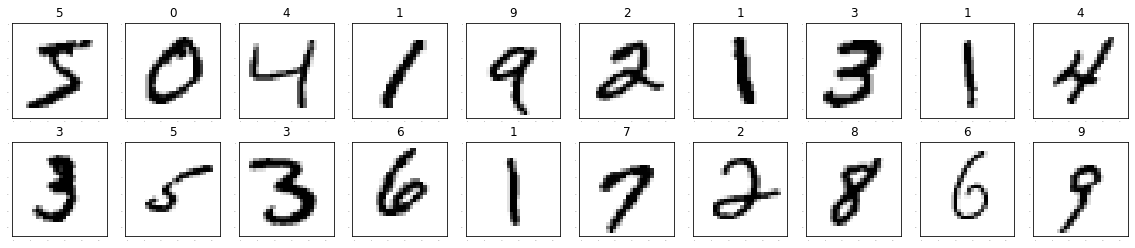

In [37]:
x_train, y_train, x_test, y_test, class_labels = get_data("mnist")
plot_imgs(20, x_train, y_train)

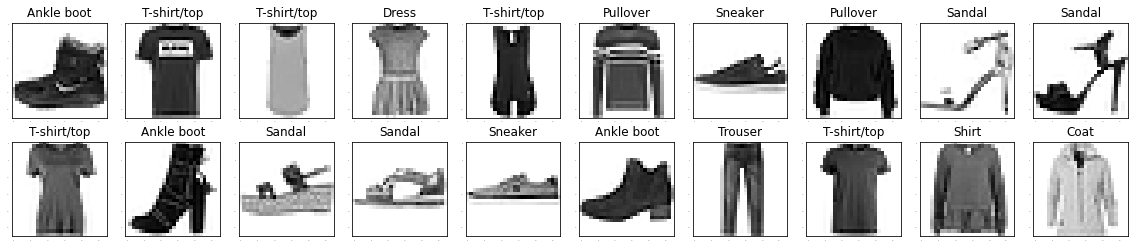

In [38]:
x_train, y_train, x_test, y_test, class_labels = get_data("fashion_mnist")
plot_imgs(20, x_train, y_train, class_labels)

## Models <a class="anchor" id="models"></a>
#### Functions <a class="anchor" id="models_func"></a>

In [39]:
def get_mlp_model():
    # MLP
    model = keras.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(10)]
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

def get_conv_model():
    # CNN
    model = keras.Sequential([
        layers.Conv2D(32, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10)]
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

def get_probability_model(model):
    """
    If we want a model with output values in [0,1] to represent probabilities, we need the SoftMax activation function.
    We could add the SoftMax layer directly as the last layer of the model when building it,
    however this is not recommended as it induces numerical approximations during training.
    So we can add it independently over the model.
    """
    probability_model = tf.keras.Sequential([
        model,
        layers.Softmax()
    ])
    return probability_model

def run_model(model_type="mlp", data="mnist", epochs = None):
    # Train chosen model on chosen data
    models = {"mlp": {
                "func": get_mlp_model,
                "default_epoch": 5},
            "cnn": {
                "func": get_conv_model,
                "default_epoch":3}
    }
    need_channels = ["cnn"]
    channels = model_type in need_channels
    # Model initialisation
    if model_type in models:
        model = models[model_type]["func"]()
        if epochs is None:
            epochs = models[model_type]["default_epoch"]
    else:
        raise("Model type does not exist")
    # Data initialisation
    x_train, y_train, x_test, y_test, class_labels = get_data(name = data, to_channels=channels)
    # Training
    print("Training : ")
    hist = model.fit(x_train, y_train, epochs=epochs)
    print("\nEvaluation : ")
    ev = model.evaluate(x_test,  y_test, verbose=1)
    return model

### Results <a class="anchor" id="models_res"></a>
#### Detailed Run <a class="anchor" id="models_res_run"></a>

In [41]:
# MLP Model on MNIST
mlp_model = get_mlp_model()
x_train, y_train, x_test, y_test, class_labels = get_data("mnist")

In [42]:
mlp_hist = mlp_model.fit(x_train, y_train, epochs=5) # Batch by 32 by default.

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2973 - accuracy: 0.9142
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1426 - accuracy: 0.9577
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1061 - accuracy: 0.9684
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0847 - accuracy: 0.9743
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0744 - accuracy: 0.9764


In [11]:
mlp_ev = mlp_model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 1s 1ms/step - loss: 0.0759 - accuracy: 0.9777


In [13]:
# Probability result on test image
pred = mlp_model(x_test[:1])
print(f"Class probabilities for test image :\n {tf.nn.softmax(pred).numpy()}")

# Same using probability model 
proba_mlp_model = get_probability_model(mlp_model)
pred2 = proba_mlp_model(x_test[:1])
print(f"Class probabilities for test image :\n {pred2.numpy()}")

Class probabilities for test image :
 [[1.4266206e-07 6.4609251e-10 5.2445893e-07 4.6425753e-06 7.1137102e-12
  1.2314234e-07 1.6805617e-12 9.9999392e-01 9.5639630e-09 5.3492590e-07]]
Class probabilities for test image :
 [[1.4266206e-07 6.4609251e-10 5.2445893e-07 4.6425753e-06 7.1137102e-12
  1.2314234e-07 1.6805617e-12 9.9999392e-01 9.5639630e-09 5.3492590e-07]]


$\Rightarrow$ probability of being a 7 : 0.9999

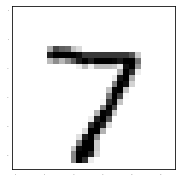

In [ ]:
plot_img(x_test[0])

#### Comparison <a class="anchor" id="models_res_comp"></a>
MNIST

In [51]:
mlp_mnist = run_model("mlp", "mnist")

Training : 
Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2959 - accuracy: 0.9147
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1402 - accuracy: 0.9584
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1082 - accuracy: 0.9681
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0878 - accuracy: 0.9723
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0770 - accuracy: 0.9757

Evaluation : 
313/313 [==============================] - 0s 1ms/step - loss: 0.0839 - accuracy: 0.9751


In [52]:
cnn_mnist = run_model("cnn", "mnist")

Training : 
Epoch 1/3
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1301 - accuracy: 0.9613
Epoch 2/3
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0411 - accuracy: 0.9873
Epoch 3/3
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0232 - accuracy: 0.9927

Evaluation : 
313/313 [==============================] - 1s 4ms/step - loss: 0.0551 - accuracy: 0.9824


Fashion MNIST

In [76]:
mlp_fmnist = run_model("mlp", "fashion_mnist")

Training : 
Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5391 - accuracy: 0.8102
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3993 - accuracy: 0.8565
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3671 - accuracy: 0.8658
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3431 - accuracy: 0.8748
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3296 - accuracy: 0.8784

Evaluation : 
313/313 [==============================] - 0s 926us/step - loss: 0.3549 - accuracy: 0.8718


In [56]:
cnn_fmnist = run_model("cnn", "fashion_mnist")

Training : 
Epoch 1/3
1875/1875 [==============================] - 32s 16ms/step - loss: 0.3737 - accuracy: 0.8672
Epoch 2/3
1875/1875 [==============================] - 29s 16ms/step - loss: 0.2465 - accuracy: 0.9090
Epoch 3/3
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1931 - accuracy: 0.9283

Evaluation : 
313/313 [==============================] - 1s 4ms/step - loss: 0.2760 - accuracy: 0.9004


## Custom Model <a class="anchor" id="custom"></a>
#### Model <a class="anchor" id="custom_mod"></a>

In [3]:
# Same model configuration as previous CNN
class CustomModel(keras.Model):
  def __init__(self):
    super(CustomModel, self).__init__()
    self.conv1 = layers.Conv2D(32, 3, activation='relu')
    self.flatten = layers.Flatten()
    self.d1 = layers.Dense(128, activation='relu')
    self.d2 = layers.Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

#### Data preparation functions <a class="anchor" id="custom_data_prep"></a>

In [4]:
def batch_data(data, label, shuffle=False, batch_size=32):
    # Prepare data for traning by batching in batch_size
    if shuffle:
        ds = tf.data.Dataset.from_tensor_slices((data, label)).shuffle(10000).batch(batch_size)
    else:
        ds = tf.data.Dataset.from_tensor_slices((data, label)).batch(batch_size)
    return ds

def get_prepared_data(name="mnist", batch_size=32):
    x_train, y_train, x_test, y_test, class_labels = get_data(name = name, to_channels=True)
    train_ds = batch_data(x_train, y_train, True, batch_size)
    test_ds = batch_data(x_test, y_test, False, batch_size)
    return train_ds, test_ds, class_labels

#### Training functions <a class="anchor" id="custom_func"></a>

In [8]:
@tf.function
def train_step(model, images, labels, loss_obj, optimizer, train_loss_obj, train_acc_obj):
  # Train step : predict batch, compute loss, compute gradient and take step
  with tf.GradientTape() as tape:
    predictions = model(images, training=True)
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    loss = loss_obj(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss_obj(loss)
  train_acc_obj(labels, predictions)

@tf.function
def test_step(model, images, labels, loss_obj, test_loss_obj, test_acc_obj):
  # Test step : predict and compute loss
  predictions = model(images, training=False)
  t_loss = loss_obj(labels, predictions)

  test_loss_obj(t_loss)
  test_acc_obj(labels, predictions)

def fit_model(model, train_ds, test_ds, epochs):

  # Modify here
  loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  optimizer = tf.keras.optimizers.Adam()
  train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
  test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

  # Fixed
  train_loss = tf.keras.metrics.Mean(name='train_loss')
  test_loss = tf.keras.metrics.Mean(name='test_loss')

  for epoch in range(epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for images, labels in train_ds:
      train_step(model, images, labels, loss_obj, optimizer, train_loss, train_acc)

    for test_images, test_labels in test_ds:
      test_step(model, test_images, test_labels, loss_obj, test_loss, test_acc)

    print(f"Epoch {epoch + 1}, Loss: {train_loss.result()}, Accuracy: {train_acc.result() * 100}, Test Loss: {test_loss.result()}, Test Accuracy: {test_acc.result() * 100}")

def evaluate(model, test_ds):
  test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
  loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  test_loss = tf.keras.metrics.Mean(name='test_loss')
  for test_images, test_labels in test_ds:
      test_step(model, test_images, test_labels, loss_obj, test_loss, test_acc)
  print(f"Loss: {test_loss.result()}, Accuracy: {test_acc.result() * 100}")

def run_custom_model(data="mnist", epochs = 3, batch_size = 32):
  model = CustomModel()
  train_ds, test_ds, class_labels = get_prepared_data(data, batch_size=batch_size)
  print("Training : ")
  fit_model(model, train_ds, test_ds, epochs)
  print("\nEvaluation : ")
  evaluate(model, test_ds)
  return model


def run_custom_model_2(data="mnist", epochs = 3, batch_size = 32):
  inputs = keras.Input((28,28,1))
  outputs = CustomModel()(inputs)
  model = keras.Model(inputs, outputs)
  train_ds, test_ds, class_labels = get_prepared_data(data, batch_size=batch_size)
  print("Training : ")
  fit_model(model, train_ds, test_ds, epochs)
  print("\nEvaluation : ")
  evaluate(model, test_ds)
  return model

#### Run <a class="anchor" id="custom_run"></a>

In [9]:
custom_model_mnist = run_custom_model("mnist", 3)

Training : 
Epoch 1, Loss: 0.13715019822120667, Accuracy: 95.87332916259766, Test Loss: 0.05976094305515289, Test Accuracy: 98.12999725341797
Epoch 2, Loss: 0.0442320853471756, Accuracy: 98.60832977294922, Test Loss: 0.048400819301605225, Test Accuracy: 98.3499984741211
Epoch 3, Loss: 0.025218859314918518, Accuracy: 99.20333862304688, Test Loss: 0.05392485857009888, Test Accuracy: 98.31999969482422

Evaluation : 
Loss: 0.05392485857009888, Accuracy: 98.31999969482422


In [151]:
# Need to rerun the cell containing the @tf.function as they can only be used once.
custom_model_fmnist = run_custom_model("fashion_mnist", 3)

Training : 
Epoch 1, Loss: 0.37237897515296936, Accuracy: 86.5816650390625, Test Loss: 0.31902825832366943, Test Accuracy: 88.29000091552734
Epoch 2, Loss: 0.246293842792511, Accuracy: 90.9316635131836, Test Loss: 0.2816442549228668, Test Accuracy: 89.88999938964844
Epoch 3, Loss: 0.19224192202091217, Accuracy: 92.81999969482422, Test Loss: 0.28733083605766296, Test Accuracy: 90.19000244140625

Evaluation : 
Loss: 0.28733083605766296, Accuracy: 90.19000244140625


## Transfer learning <a class="anchor" id="tl"></a>
#### Functions <a class="anchor" id="tl_func"></a>

In [3]:
def get_tl_model():
    # Load a convolutional base with pre-trained weights
    base_model = keras.applications.Xception(
        weights='imagenet',
        include_top=False,
        pooling='avg')

    # Freeze the base model
    base_model.trainable = False
    # Use a Sequential model to add a trainable classifier on top
    model = keras.Sequential([
        base_model,
        layers.Dense(10)])

    # Compile & train
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

def resize_numpy(images, n_times):
    # Exact rescaling of image by repeating n times the values
    if len(images.shape) == 3:
        big_images = images.repeat(n_times, axis=0).repeat(n_times, axis=1)
    else:
        big_images = images.repeat(n_times, axis=1).repeat(n_times, axis=2)
    return big_images

def resize_tf(images, new_h, new_w):
    # Rescaling of the image using interpolation
    # Allows to rescale to any resolution
    # Way slower than with numpy
    if not isinstance(images, tf.Tensor):
        images = tf.constant(images)
        dtype = images.numpy().dtype
    big_images = tf.image.resize(images, (new_h, new_w))
    return big_images.numpy().astype(dtype)

def grey_to_rgb_numpy(images):
    # Converts images of shape (X, Y, 1) to (X, Y, 3)
    rgb_images = np.repeat(images, 3, -1)
    return rgb_images

def grey_to_rgb_tf(images):
    # Converts images of shape (X, Y, 1) to (X, Y, 3)
    if not isinstance(images, tf.Tensor):
        images = tf.constant(images)
    rgb_images = tf.image.grayscale_to_rgb(images)
    return rgb_images.numpy()

def prepare_data_tl(images, n_times=3):
    # Rescale and add RGB channels
    return grey_to_rgb_numpy(resize_numpy(images, n_times))

#### Run <a class="anchor" id="tl_run"></a>

In [4]:
tl_model = get_tl_model()
x_train, y_train, x_test, y_test, class_labels = get_data(name = "fashion_mnist", to_channels=True, as_type='float16')
print("Scaling train...")
x_train = prepare_data_tl(x_train)
print("Scaling test...")
x_test = prepare_data_tl(x_test)

2023-02-02 20:43:38.057500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Scaling train...
Scaling test...


In [6]:
# Training
print("Training : ")
hist = tl_model.fit(x_train, y_train, epochs=2)
print("\nEvaluation : ")
ev = tl_model.evaluate(x_test,  y_test, verbose=1)

Training : 
Epoch 1/2
1875/1875 [==============================] - 521s 275ms/step - loss: 0.4940 - accuracy: 0.8300
Epoch 2/2
1875/1875 [==============================] - 538s 287ms/step - loss: 0.3754 - accuracy: 0.8671

Evaluation : 
313/313 [==============================] - 89s 278ms/step - loss: 0.4091 - accuracy: 0.8611
